In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics




sns.set()
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/flight-fare-prediction-mh/Data_Train.xlsx
/kaggle/input/flight-fare-prediction-mh/Sample_submission.xlsx
/kaggle/input/flight-fare-prediction-mh/Test_set.xlsx


In [2]:
# importing the data set 
train_data = pd.read_excel("/kaggle/input/flight-fare-prediction-mh/Data_Train.xlsx")

# Flight Price Prediction Dataset:

* The Flight Price Prediction Dataset provides relevant information for predicting flight prices, and we need to follow several steps to work with this dataset effectively:

## Loading the Dataset
* Since the dataset is in the form of an Excel file, we can use the pandas read_excel function to import the data and create a pandas DataFrame.

## Data Inspection
* Once we have loaded the dataset, it is critical to inspect the data thoroughly to reveal any hidden information, such as missing values in rows or columns. We must verify whether any null values are present, and if so, we can choose from the following methods to handle them:

* Utilize the imputation method in scikit-learn to impute the missing data
* Apply the fillna() method to fill the NaN values with mean, median, or mode values
## Data Description
* Using the describe() method, we can gain statistical insights into the dataset. This can help us understand the data distribution and spot any outliers that might impact our predictions.

* In conclusion, by following these steps, we can prepare the Flight Price Prediction Dataset for use in a machine learning model that predicts flight prices with greater accuracy.

In [3]:

 
train_data.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302


In [4]:
def remove_null_values(df):
    """
    Remove null values from a DataFrame if any are found, otherwise return the original DataFrame.
    
    Args:
    df (pandas.DataFrame): The DataFrame to check for null values.
    
    Returns:
    pandas.DataFrame: The DataFrame with null values removed if any were found, otherwise the original DataFrame.
    """
    if df.isnull().sum().sum() > 0:
        df.dropna(inplace=True)
        print("Null values removed from DataFrame.")
    else:
        print("No null values found in DataFrame.")
    
    return df


train_data = remove_null_values(train_data)

Null values removed from DataFrame.


In [5]:
print(f"DataFrame head:\n{train_data.head()}\n")
print(f"DataFrame info:\n{train_data.info()}\n")
print(f"Number of null values in DataFrame:\n{train_data.isnull().sum()}\n")

DataFrame head:
       Airline Date_of_Journey    Source Destination                  Route  \
0       IndiGo      24/03/2019  Banglore   New Delhi              BLR → DEL   
1    Air India       1/05/2019   Kolkata    Banglore  CCU → IXR → BBI → BLR   
2  Jet Airways       9/06/2019     Delhi      Cochin  DEL → LKO → BOM → COK   
3       IndiGo      12/05/2019   Kolkata    Banglore        CCU → NAG → BLR   
4       IndiGo      01/03/2019  Banglore   New Delhi        BLR → NAG → DEL   

  Dep_Time  Arrival_Time Duration Total_Stops Additional_Info  Price  
0    22:20  01:10 22 Mar   2h 50m    non-stop         No info   3897  
1    05:50         13:15   7h 25m     2 stops         No info   7662  
2    09:25  04:25 10 Jun      19h     2 stops         No info  13882  
3    18:05         23:30   5h 25m      1 stop         No info   6218  
4    16:50         21:35   4h 45m      1 stop         No info  13302  

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10682 entries, 0 to 10682
Data c

# Exploratory Data Analysis (EDA)

Based on the data description, it is evident that the Date_of_Journey column is of object data type. Consequently, in order to utilize this column effectively for prediction purposes, it is necessary to convert this data type into a timestamp format.

To accomplish this task, we can utilize the pandas `to_datetime` function to convert the object data type to a datetime dtype.

The `.dt.day method` extracts only the day component of the date, while the `.dt.month method` extracts only the month component of the date.

In [6]:
import pandas as pd

def extract_date_time_info(df, date_col, dep_time_col, arrival_time_col, duration_col):
    """
    Extracts date and time information from the specified columns of the given DataFrame.
    
    Args:
    - df (pandas.DataFrame): The DataFrame containing the columns to extract information from.
    - date_col (str): The name of the column containing the date information in "DD/MM/YYYY" format.
    - dep_time_col (str): The name of the column containing the departure time information in "HH:MM" format.
    - arrival_time_col (str): The name of the column containing the arrival time information in "HH:MM" format.
    - duration_col (str): The name of the column containing the duration information in "Xh Ym" or "Xh" or "Ym" format.
    
    Returns:
    - pandas.DataFrame: The DataFrame with extracted date and time information, and dropped columns.
    """
    # Extract journey day and month from date column
    df["Journey_day"] = pd.to_datetime(df[date_col], format="%d/%m/%Y").dt.day
    df["Journey_month"] = pd.to_datetime(df[date_col], format="%d/%m/%Y").dt.month
    df.drop([date_col], axis=1, inplace=True)

    # Extract departure hour and minute from departure time column
    df["Dep_hour"] = pd.to_datetime(df[dep_time_col]).dt.hour
    df["Dep_min"] = pd.to_datetime(df[dep_time_col]).dt.minute
    df.drop([dep_time_col], axis=1, inplace=True)

    # Extract arrival hour and minute from arrival time column
    df["Arrival_hour"] = pd.to_datetime(df[arrival_time_col]).dt.hour
    df["Arrival_min"] = pd.to_datetime(df[arrival_time_col]).dt.minute
    df.drop([arrival_time_col], axis=1, inplace=True)

    # Extract duration hours and minutes from duration column
    duration_hours = []
    duration_mins = []
    for duration in df[duration_col]:
        hours = 0
        mins = 0
        duration_parts = duration.split()
        if len(duration_parts) == 2:
            hours = int(duration_parts[0][:-1])
            mins = int(duration_parts[1][:-1])
        elif "h" in duration_parts[0]:
            hours = int(duration_parts[0][:-1])
        else:
            mins = int(duration_parts[0][:-1])
        duration_hours.append(hours)
        duration_mins.append(mins)
    df["Duration_hours"] = duration_hours
    df["Duration_mins"] = duration_mins
    df.drop([duration_col], axis=1, inplace=True)

    return df


In [7]:
df = extract_date_time_info(train_data, "Date_of_Journey", "Dep_Time", "Arrival_Time", "Duration")


In [8]:
df

,Airline,Source,Destination,Route,Total_Stops,Additional_Info,Price,Journey_day,Journey_month,Dep_hour,Dep_min,Arrival_hour,Arrival_min,Duration_hours,Duration_mins
0,IndiGo,Banglore,New Delhi,BLR → DEL,non-stop,No info,3897,24,3,22,20,1,10,2,50
1,Air India,Kolkata,Banglore,CCU → IXR → BBI → BLR,2 stops,No info,7662,1,5,5,50,13,15,7,25
2,Jet Airways,Delhi,Cochin,DEL → LKO → BOM → COK,2 stops,No info,13882,9,6,9,25,4,25,19,0
3,IndiGo,Kolkata,Banglore,CCU → NAG → BLR,1 stop,No info,6218,12,5,18,5,23,30,5,25
4,IndiGo,Banglore,New Delhi,BLR → NAG → DEL,1 stop,No info,13302,1,3,16,50,21,35,4,45
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10678,Air Asia,Kolkata,Banglore,CCU → BLR,non-stop,No info,4107,9,4,19,55,22,25,2,30
10679,Air India,Kolkata,Banglore,CCU → BLR,non-stop,No info,4145,27,4,20,45,23,20,2,35
10680,Jet Airways,Banglore,Delhi,BLR → DEL,non-stop,No info,7229,27,4,8,20,11,20,3,0
10681,Vistara,Banglore,New Delhi,BLR → DEL,non-stop,No info,12648,1,3,11,30,14,10,2,40


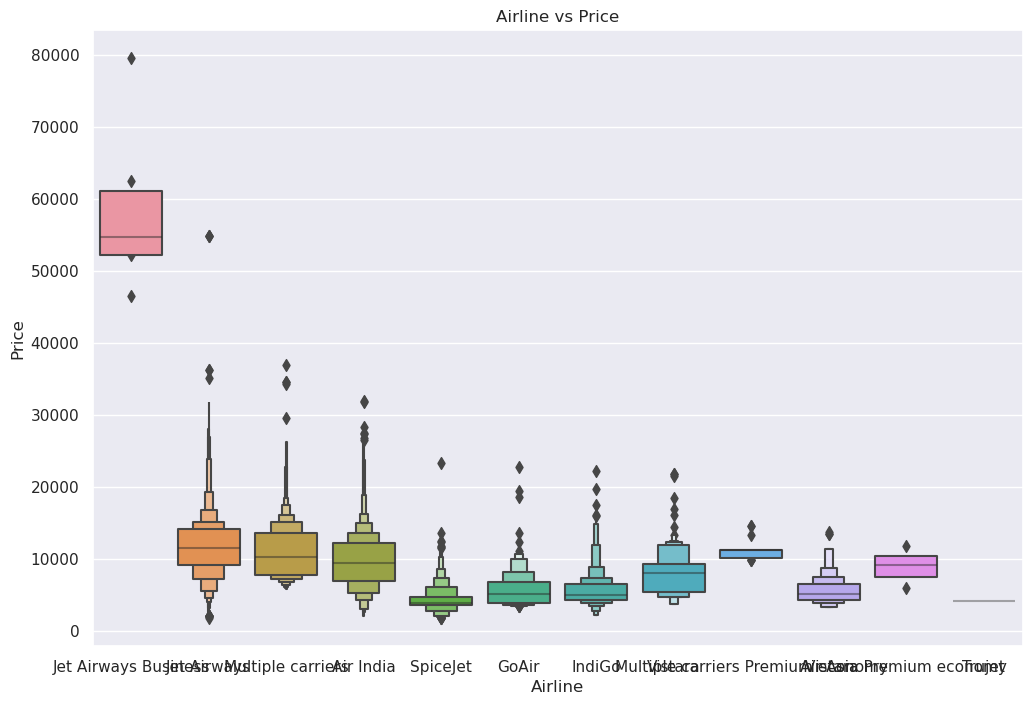

In [9]:
# Create a boxen plot showing Airline vs Price
fig, ax = plt.subplots(figsize=(12, 8))
sns.boxenplot(x="Airline", y="Price", data=df.sort_values("Price", ascending=False), ax=ax)
ax.set_title("Airline vs Price")
ax.set_xlabel("Airline")
ax.set_ylabel("Price")
plt.show()



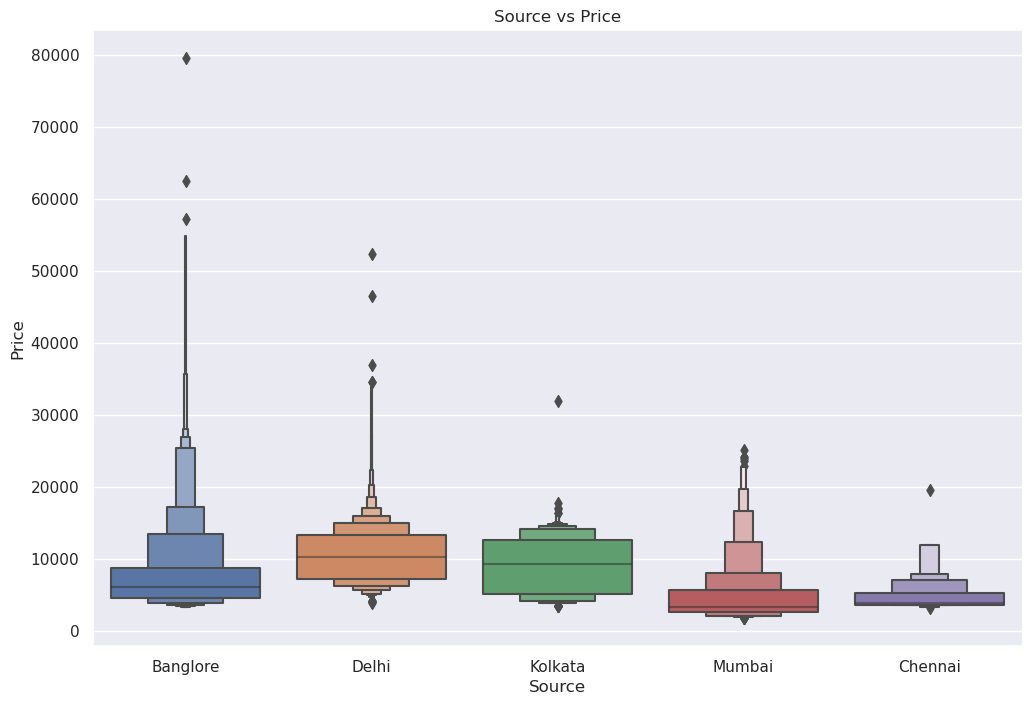

In [10]:
# Create a boxen plot showing Source vs Price
fig, ax = plt.subplots(figsize=(12, 8))
sns.boxenplot(x="Source", y="Price", data=df.sort_values("Price", ascending=False), ax=ax)
ax.set_title("Source vs Price")
ax.set_xlabel("Source")
ax.set_ylabel("Price")
plt.show()



In [11]:
def One_hot_encoding_train_data(train_data):
    """
    One-hot encode categorical columns in train_data and replace stop information with integer values.

    Args:
    train_data (pd.DataFrame): input dataframe with categorical columns to be one-hot encoded and stop information to be replaced with integer values.

    Returns:
    pd.DataFrame: one-hot encoded dataframe with replaced stop information and original categorical columns dropped.
    """

    # One-hot encode Airline
    Airline = pd.get_dummies(train_data[["Airline"]], drop_first=True)
    
    # One-hot encode Source
    Source = pd.get_dummies(train_data[["Source"]], drop_first=True)
    
    # One-hot encode Destination
    Destination = pd.get_dummies(train_data[["Destination"]], drop_first=True)
    
    # Replace "non-stop", "1 stop", etc. with 0, 1, etc.
    train_data.replace({"non-stop": 0, "1 stop": 1, "2 stops": 2, "3 stops": 3, "4 stops": 4}, inplace=True)
    
    # Drop original categorical columns
    train_data.drop(["Airline", "Source", "Destination", "Additional_Info","Route"], axis=1, inplace=True)
    
    # Concatenate one-hot encoded columns and drop original categorical columns
    data_train = pd.concat([train_data, Airline, Source, Destination], axis=1)
    
    # Return the one-hot encoded dataframe with replaced stop information and original categorical columns dropped
    return data_train


In [12]:
df = One_hot_encoding_train_data(df)
test_data = pd.read_excel(r"/kaggle/input/flight-fare-prediction-mh/Test_set.xlsx")
test_data = remove_null_values(test_data)
test_data_df = extract_date_time_info(test_data, "Date_of_Journey", "Dep_Time", "Arrival_Time", "Duration")
test_data_df = One_hot_encoding_train_data(test_data_df)

No null values found in DataFrame.


In [13]:
df

,Total_Stops,Price,Journey_day,Journey_month,Dep_hour,Dep_min,Arrival_hour,Arrival_min,Duration_hours,Duration_mins,...,Airline_Vistara Premium economy,Source_Chennai,Source_Delhi,Source_Kolkata,Source_Mumbai,Destination_Cochin,Destination_Delhi,Destination_Hyderabad,Destination_Kolkata,Destination_New Delhi
0,0,3897,24,3,22,20,1,10,2,50,...,0,0,0,0,0,0,0,0,0,1
1,2,7662,1,5,5,50,13,15,7,25,...,0,0,0,1,0,0,0,0,0,0
2,2,13882,9,6,9,25,4,25,19,0,...,0,0,1,0,0,1,0,0,0,0
3,1,6218,12,5,18,5,23,30,5,25,...,0,0,0,1,0,0,0,0,0,0
4,1,13302,1,3,16,50,21,35,4,45,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10678,0,4107,9,4,19,55,22,25,2,30,...,0,0,0,1,0,0,0,0,0,0
10679,0,4145,27,4,20,45,23,20,2,35,...,0,0,0,1,0,0,0,0,0,0
10680,0,7229,27,4,8,20,11,20,3,0,...,0,0,0,0,0,0,1,0,0,0
10681,0,12648,1,3,11,30,14,10,2,40,...,0,0,0,0,0,0,0,0,0,1


In [14]:
test_data_df

,Total_Stops,Journey_day,Journey_month,Dep_hour,Dep_min,Arrival_hour,Arrival_min,Duration_hours,Duration_mins,Airline_Air India,...,Airline_Vistara Premium economy,Source_Chennai,Source_Delhi,Source_Kolkata,Source_Mumbai,Destination_Cochin,Destination_Delhi,Destination_Hyderabad,Destination_Kolkata,Destination_New Delhi
0,1,6,6,17,30,4,25,10,55,0,...,0,0,1,0,0,1,0,0,0,0
1,1,12,5,6,20,10,20,4,0,0,...,0,0,0,1,0,0,0,0,0,0
2,1,21,5,19,15,19,0,23,45,0,...,0,0,1,0,0,1,0,0,0,0
3,1,21,5,8,0,21,0,13,0,0,...,0,0,1,0,0,1,0,0,0,0
4,0,24,6,23,55,2,45,2,50,0,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2666,1,6,6,20,30,20,25,23,55,1,...,0,0,0,1,0,0,0,0,0,0
2667,0,27,3,14,20,16,55,2,35,0,...,0,0,0,1,0,0,0,0,0,0
2668,1,6,3,21,50,4,25,6,35,0,...,0,0,1,0,0,1,0,0,0,0
2669,1,6,3,4,0,19,15,15,15,1,...,0,0,1,0,0,1,0,0,0,0


## Feature selection 

* Feature selection is a technique used to determine the most significant features that have a strong correlation with the target variable. There are various methods for feature selection, including:

* Heatmap analysis: This method involves creating a graphical representation of the correlation between each feature and the target variable.

* Feature importance assessment: This method involves assessing the importance of each feature based on their contribution to the overall performance of the model.

* SelectKBest: This method involves selecting the top K features that have the strongest correlation with the target variable.

In [15]:
df.shape

(10682, 30)

In [16]:
#find out correlationn between the features
df.corr()

,Total_Stops,Price,Journey_day,Journey_month,Dep_hour,Dep_min,Arrival_hour,Arrival_min,Duration_hours,Duration_mins,...,Airline_Vistara Premium economy,Source_Chennai,Source_Delhi,Source_Kolkata,Source_Mumbai,Destination_Cochin,Destination_Delhi,Destination_Hyderabad,Destination_Kolkata,Destination_New Delhi
Total_Stops,1.000000,0.603897,-0.009451,0.054383,-0.061476,-0.002618,0.038140,-0.106940,0.739916,-0.136706,...,-0.020459,-0.234758,0.490170,0.032761,-0.260752,0.490170,-0.447390,-0.260752,-0.234758,-0.015302
Price,0.603897,1.000000,-0.153774,-0.103643,0.006799,-0.024458,0.024244,-0.086155,0.508778,-0.124855,...,-0.000454,-0.179223,0.270676,0.009358,-0.230755,0.270676,-0.313417,-0.230755,-0.179223,0.189777
Journey_day,-0.009451,-0.153774,1.000000,-0.038359,0.002170,-0.008170,-0.003245,-0.017510,-0.022059,-0.008940,...,-0.020115,0.006611,0.100088,-0.060558,-0.014030,0.100088,0.002632,-0.014030,0.006611,-0.075254
Journey_month,0.054383,-0.103643,-0.038359,1.000000,0.039127,-0.059267,-0.003927,-0.100626,0.016141,-0.040897,...,-0.019797,0.005650,0.139222,0.087177,-0.039352,0.139222,0.090490,-0.039352,0.005650,-0.453685
Dep_hour,-0.061476,0.006799,0.002170,0.039127,1.000000,-0.024745,0.005180,0.067911,0.002869,-0.023707,...,-0.003375,-0.014846,-0.118780,0.155471,-0.017292,-0.118780,0.009469,-0.017292,-0.014846,-0.022138
Dep_min,-0.002618,-0.024458,-0.008170,-0.059267,-0.024745,1.000000,0.043122,-0.017597,-0.022104,0.092485,...,-0.011380,0.067110,-0.085534,-0.024238,0.037705,-0.085534,0.003200,0.037705,0.067110,0.107129
Arrival_hour,0.038140,0.024244,-0.003245,-0.003927,0.005180,0.043122,1.000000,-0.154363,0.055276,-0.118309,...,0.000776,-0.014795,-0.006790,0.054693,-0.033512,-0.006790,-0.030867,-0.033512,-0.014795,0.000366
Arrival_min,-0.106940,-0.086155,-0.017510,-0.100626,0.067911,-0.017597,-0.154363,1.000000,-0.074450,0.151628,...,0.000314,-0.030493,-0.209882,0.118573,0.081196,-0.209882,0.095250,0.081196,-0.030493,0.021271
Duration_hours,0.739916,0.508778,-0.022059,0.016141,0.002869,-0.022104,0.055276,-0.074450,1.000000,-0.126468,...,-0.016268,-0.186668,0.299819,0.123524,-0.233326,0.299819,-0.346192,-0.233326,-0.186668,0.004052
Duration_mins,-0.136706,-0.124855,-0.008940,-0.040897,-0.023707,0.092485,-0.118309,0.151628,-0.126468,1.000000,...,0.004952,-0.098823,-0.154126,0.013761,-0.018761,-0.154126,0.218207,-0.018761,-0.098823,0.079866


In [17]:
y = df.pop('Price')
X = df
X = np.array(X)
y = np.array(y)

In [18]:
 # Use ExtraTreesRegressor to find feature importances

selection = ExtraTreesRegressor()
selection.fit(X, y)

print(selection.feature_importances_)

[2.44129597e-01 1.44081608e-01 5.25109792e-02 2.42596423e-02
 2.12306283e-02 2.82352318e-02 1.88900430e-02 1.17050277e-01
 1.77948947e-02 9.56367071e-03 1.90976514e-03 2.07484946e-02
 1.28674825e-01 6.73465132e-02 1.82938406e-02 8.64736479e-04
 3.72221517e-03 1.10427403e-04 5.00460922e-03 8.15939241e-05
 5.06799199e-04 9.81073561e-03 3.38466908e-03 5.58626399e-03
 1.39620292e-02 1.15074139e-02 5.38637657e-03 5.29146660e-04
 2.48229734e-02]


## Model 

In [19]:
# Scale data
scaler = StandardScaler()
X_norm = scaler.fit_transform(X)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_norm, y, test_size=0.2, random_state=42,shuffle=True)





# Create pipeline for the model
model_pipeline = make_pipeline(DecisionTreeRegressor(max_depth=10 , min_samples_leaf= 1 , min_samples_split= 4 ))

# Use cross-validation to estimate model performance
cv_scores = cross_val_score(model_pipeline, X_train, y_train, cv=10, scoring='r2')
print(f'Mean cross-validation R-squared score: {cv_scores.mean()}')

# Train the decision tree regression model
model = model_pipeline.fit(X_train, y_train)

# Evaluate the model on the testing set
y_pred = model.predict(X_test)
mse = ((y_pred - y_test) ** 2).mean()
r2 = model.score(X_test, y_test)
print(f'Testing set R-squared: {r2:.2f}')
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))
print('MSE:', metrics.mean_squared_error(y_test, y_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean cross-validation R-squared score: 0.7658402729415725
Testing set R-squared: 0.78
MAE: 1353.2473065306738
MSE: 4818969.441046707
RMSE: 2195.2151240930143


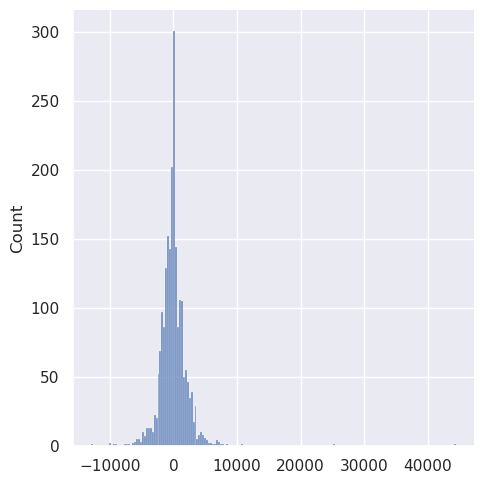

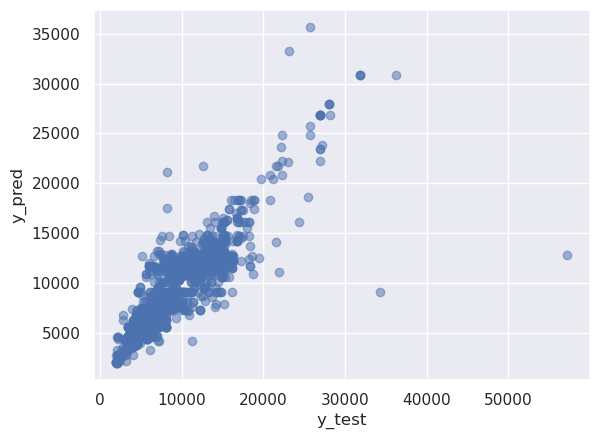

In [20]:
sns.displot(y_test-y_pred)
plt.show()
plt.scatter(y_test, y_pred, alpha = 0.5)
plt.xlabel("y_test")
plt.ylabel("y_pred")
plt.show()

# Hyperparameter tunnig

In [21]:
# Define hyperparameters to search over
param_grid = {
    'decisiontreeregressor__max_depth': [2, 4, 6, 8, 10,12,14,16,18,20],
    'decisiontreeregressor__min_samples_split': [2, 4, 6, 8, 10,12,14,16,18,20],
    'decisiontreeregressor__min_samples_leaf': [1, 2, 4, 8,10,12,14,16,18,20],
}

# Use grid search cross-validation to estimate model performance and find the best hyperparameters
grid_search = GridSearchCV(model_pipeline, param_grid, cv=10, scoring='r2')
grid_search.fit(X_train, y_train)

# Print the best hyperparameters and the corresponding cross-validation score
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation R-squared score: {grid_search.best_score_}")

# Train the decision tree regression model using the best hyperparameters found by grid search
best_model = grid_search.best_estimator_.fit(X_train, y_train)

# Evaluate the model on the testing set
y_pred = best_model.predict(X_test)
mse = ((y_pred - y_test) ** 2).mean()
r2 = best_model.score(X_test, y_test)
print(f'Testing set R-squared: {r2:.2f}')
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))
print('MSE:', metrics.mean_squared_error(y_test, y_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Best parameters: {'decisiontreeregressor__max_depth': 12, 'decisiontreeregressor__min_samples_leaf': 2, 'decisiontreeregressor__min_samples_split': 4}
Best cross-validation R-squared score: 0.7892806387920295
Testing set R-squared: 0.79
MAE: 1221.6975858990045
MSE: 4492544.652967611
RMSE: 2119.5623729835393


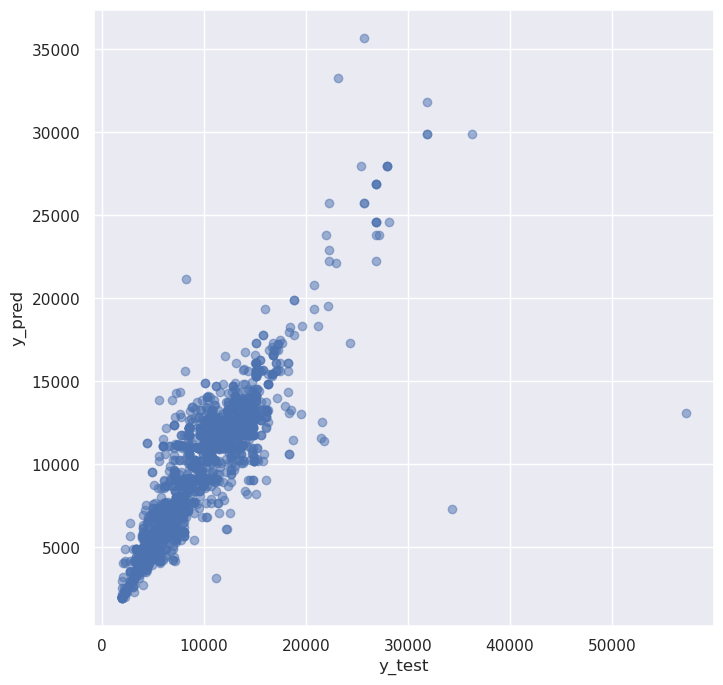

In [22]:
plt.figure(figsize = (8,8))
plt.scatter(y_test,y_pred, alpha = 0.5)
plt.xlabel("y_test")
plt.ylabel("y_pred")
plt.show()
